### 생선 분류 - 최적의 K 찾기 : 하이퍼파라미터
- 데이터셋 : fish.csv
- 피쳐/특성 : Weight, Length
- 타겟/라벨 : Species
- 학습방법 : 지도학습 => 분류
- 학습알고리즘 : 최근접이웃알고리즘
- 하이퍼파라미터 튜닝 : 모델 성능 개선

[1] 데이터 준비

In [67]:
import pandas as pd
import matplotlib.pyplot as plt


In [68]:
DATA_FILE='../data/fish.csv'
DATA_FILE

'../data/fish.csv'

In [69]:
# 행 : Bream, Smelt, 컬럼: Species, Weight, Height => 0, 1, 2
fishDF=pd.read_csv(DATA_FILE, usecols=[0,1,2])
fishDF.head(3)

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


In [70]:
mask=(fishDF['Species']=='Bream') | (fishDF['Species']=='Smelt')
twoDF=fishDF[mask]
twoDF.reset_index(drop=True, inplace=True)
twoDF.index

RangeIndex(start=0, stop=49, step=1)

In [71]:
# Species 컬럼을 수치화  => Bream 0, Smelt 1
new_cols=twoDF.loc[:,'Species'].replace({'Bream':0, 'Smelt':1})
twoDF['FCode']=new_cols

C:\Users\kdp\AppData\Local\Temp\ipykernel_11476\215539170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoDF['FCode']=new_cols


In [72]:
twoDF.head()

,Species,Weight,Length,FCode
0,Bream,242.0,25.4,0
1,Bream,290.0,26.3,0
2,Bream,340.0,26.5,0
3,Bream,363.0,29.0,0
4,Bream,430.0,29.0,0


[2] 피쳐와 타겟 분리

In [73]:
features=twoDF[['Weight','Length']]
target=twoDF['FCode']

print(f'features => {features.shape}, {features.ndim}D')
print(f'target => {target.shape}, {target.ndim}D')

features => (49, 2), 2D
target => (49,), 1D


[3] 데이터셋 준비 => 학습용, 테스트용

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
# train:test = 80:20  ===> test_size=0.2 or train_size=0.8
# stratify 매개변수 : 분류일 경우 사용, 분류 타겟의 종류에 대한 비율을 고려
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=10)


In [76]:
print(f'X_train : {X_train.shape}, {X_train.ndim}D')
print(f'Y_train : {Y_train.shape}, {Y_train.ndim}D')

print(f'X_test : {X_test.shape}, {X_test.ndim}D')
print(f'Y_test : {Y_test.shape}, {Y_test.ndim}D')

X_train : (39, 2), 2D
Y_train : (39,), 1D
X_test : (10, 2), 2D
Y_test : (10,), 1D


In [77]:
# target 0(Bream), 1(Smelt) 비율
Y_train.value_counts()[0]/Y_train.shape[0], Y_train.value_counts()[1]/Y_train.shape[0]

(0.717948717948718, 0.28205128205128205)

In [78]:
Y_test.value_counts()[0]/Y_test.shape[0], Y_test.value_counts()[1]/Y_test.shape[0]

(0.7, 0.3)

[3-2] 피쳐 스케일링

In [79]:
from sklearn.preprocessing import MinMaxScaler

In [80]:
# 스케일러 인스턴스 생성
mmScaler=MinMaxScaler()


In [81]:
# 데이터에 기반한 MinMaxScaler 동작을 위한 학습 진행
mmScaler.fit(X_train)

MinMaxScaler()

In [82]:
mmScaler.min_, mmScaler.data_min_, mmScaler.scale_, mmScaler.data_max_

(array([-0.00674519, -0.31410256]),
 array([6.7, 9.8]),
 array([0.00100675, 0.03205128]),
 array([1000.,   41.]))

In [83]:
# 학습용 데이터셋 스케일링 ==> ndarray 타입 반환
X_train_scaled=mmScaler.transform(X_train)
X_train_scaled.shape

(39, 2)

In [84]:
# 테스트용 데이터셋 ==> 스케일링 ==> ndarray 타입 반환
X_test_scaled= mmScaler.transform(X_test)
X_test_scaled.shape, X_test_scaled.min(), X_test_scaled.max()

((10, 2), 0.0033222591362126247, 0.8489882210812445)

[4] 훈련/학습 진행
- 학습 알고리즘 인스턴스 생성
- 학습진행 => fit()

In [85]:
from sklearn.neighbors import KNeighborsClassifier

In [86]:
# 인스턴스 생성
model=KNeighborsClassifier()

In [87]:
# 학습 진행 ==> 학습용 데이터셋
model.fit(X_train_scaled, Y_train)

KNeighborsClassifier()

In [88]:
# 학습 후 모델 파라미터 확인
model.classes_, model.n_samples_fit_
# model.feature_names_in_  <== ndarray일 경우 컬럼명 X

(array([0, 1], dtype=int64), 39)

[5] 모델 성능평가 ===> score() 메서드 + 테스트 데이터셋

In [89]:
model.score(X_test_scaled, Y_test)

1.0

[6] 최적의 K 개수 찾기 ==> 모델의 성능 영향 미치는 파라미터
- 하이퍼파라미터

In [109]:
# K의 범위 : 1~ 전체 데이터 개수
scores, points=[],[]

for k in range(1, 40):
    # 최근접 이웃 데이터 수 설정
    # model=KNeighborsClassifier(n_neighbors=k)  모델을 새로 만든다는 뜻
    model.n_neighbors=k

    # 모델 예측 값 추출
    model.fit(X_train_scaled,Y_train)

    # 점수 계산 및 저장
    jumsu=model.score(X_test_scaled, Y_test)
    # print(f'[{k}] jumsu => {jumsu}')
    
    if k>1:
        if jumsu != scores[-1]:
            points.append(k)
    scores.append(jumsu)



In [110]:
points

[22]

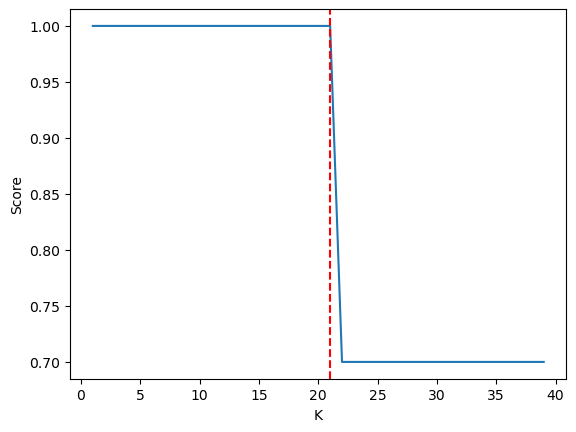

In [117]:
# x축 k, y축 점수
plt.plot(range(1,40), scores)
plt.xlabel('K')
plt.ylabel("Score")
plt.axvline(points[0]-1,0.0,1.0,color='red', linestyle='dashed')
plt.show()

[7] 예측 하기 ===> 학습/훈련과 테스트에 사용되지 않은 데이터 사용
- 주의 : 입력 데이터 ==> 2D

In [90]:
new_data = pd.DataFrame([[413,27.8]], columns=['Weight','Length'])
new_data

,Weight,Length
0,413,27.8


In [91]:
new_data_scaled= mmScaler.transform(new_data)
new_data_scaled

array([[0.40904057, 0.57692308]])

In [92]:
model.predict(new_data_scaled)

array([0], dtype=int64)

In [93]:
### 최근접한 k개 데이터 찾기
distance, index=model.kneighbors(new_data_scaled)

In [94]:
distance

array([[0.04209753, 0.06334927, 0.07138647, 0.07421737, 0.07974703]])

In [95]:
neighbors=index.reshape(-1).tolist()
X_train_scaled[neighbors]

array([[0.42615524, 0.61538462],
       [0.35870331, 0.61538462],
       [0.44629014, 0.63782051],
       [0.38588543, 0.6474359 ],
       [0.44629014, 0.6474359 ]])

In [96]:
k_weight=X_train_scaled[neighbors][:,0]
k_length=X_train_scaled[neighbors][:,1]

print(new_data_scaled)
print(k_weight,k_length, sep='\n')

[[0.40904057 0.57692308]]
[0.42615524 0.35870331 0.44629014 0.38588543 0.44629014]
[0.61538462 0.61538462 0.63782051 0.6474359  0.6474359 ]


In [97]:
twoDF.iloc[neighbors]

,Species,Weight,Length,FCode
25,Bream,725.0,35.0,0
22,Bream,620.0,34.5,0
21,Bream,685.0,34.0,0
0,Bream,242.0,25.4,0
6,Bream,500.0,29.7,0


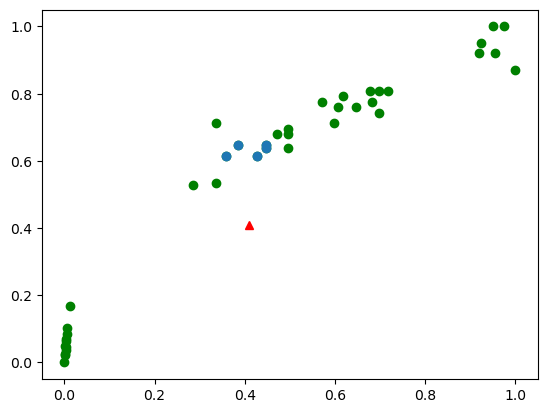

In [98]:
### 시각화로 확인
plt.scatter(X_train_scaled[:,0],X_train_scaled[:,1], color='green')
# plt.scatter(twoDF.loc[35:,'Weight'],twoDF.loc[35:,'Length'])
plt.plot(new_data_scaled[0,0],new_data_scaled[0,0], 'r^')
plt.scatter(k_weight,k_length)
plt.show()